In [1]:
from imgtools.io import read_dicom_series
from readii.loaders import loadSegmentation
from readii.image_processing import *
from readii.negative_controls import applyNegativeControl, makeShuffleImage, negativeControlROIOnly, negativeControlNonROIOnly
import numpy.ma as ma 

In [ ]:
baseImage = read_dicom_series("../tests/NSCLC_Radiogenomics/R01-001/09-06-1990-NA-CT_CHEST_ABD_PELVIS_WITH_CON-98785/3.000000-THORAX_1.0_B45f-95741")

segImages = loadSegmentation("../tests/NSCLC_Radiogenomics/R01-001/09-06-1990-NA-CT_CHEST_ABD_PELVIS_WITH_CON-98785/1000.000000-3D_Slicer_segmentation_result-67652/1-1.dcm",
                            modality = 'SEG')
roiImage = segImages['Heart']
flattenedROIImage = flattenImage(roiImage)
baseROI = alignImages(baseImage, flattenedROIImage)

roiLabel = getROIVoxelLabel(baseROI)

randomSeed = 10

In [2]:
# ctDirPath = "/Users/katyscott/Documents/HNC Project/data/error_images/RADCURE/RADCURE-2012/12-26-2001-NA-Research HNC Planning CT-39063/3.000000-Helical Axial-26282"
# segFilePath = "/Users/katyscott/Documents/HNC Project/data/error_images/RADCURE/RADCURE-2012/12-26-2001-NA-Research HNC Planning CT-39063/1.000000-NA-03155/1-1.dcm"

ctDirPath = "/Users/katyscott/Documents/HNC Project/data/error_images/RADCURE/RADCURE-3716/20091006-Research HNC Planning CT-1.3.6.1.4.1.14519.5.2.1.159479891309173287983489538813569798675/3-Neck 2.0 CE-1.3.6.1.4.1.14519.5.2.1.303618333208483957981299429120448318183"
segFilePath = "/Users/katyscott/Documents/HNC Project/data/error_images/RADCURE/RADCURE-3716/20091006-Research HNC Planning CT-1.3.6.1.4.1.14519.5.2.1.159479891309173287983489538813569798675/1-UnknownSeriesDescription-1.3.6.1.4.1.14519.5.2.1.53689980185072466582338154816320570464/1.3.6.1.4.1.14519.5.2.1.196814539827040265136159678638398372874.dcm"

baseImage = read_dicom_series(ctDirPath)
segImages = loadSegmentation(segFilePath, "RTSTRUCT", ctDirPath, roiNames="GTVp.*")

roiImage = segImages["GTVp"]
baseROI = alignImages(baseImage, roiImage)

labels: {'GTVp': 0}


In [ ]:
# convert CT to array
arrBaseImage = sitk.GetArrayFromImage(baseImage)

# convert baseROI to array
arrBaseROI = sitk.GetArrayFromImage(baseROI)

# make binary mask out of ROI (NaN for background, 1 for ROI)
binBaseROI = np.where(arrBaseROI > 0, 1, np.NaN)

# multiply the mask by the CT to get just ROI voxels
roiMaskedBaseImage = arrBaseImage * binBaseROI

In [ ]:
maxROIVoxelVal = int(np.nanmax(roiMaskedBaseImage))
minROIVoxelVal = int(np.nanmin(roiMaskedBaseImage))

In [ ]:
arrNewBaseImage = arrBaseImage.copy()

In [ ]:
arrRandomSampledImage = sitk.GetArrayFromImage(randomSampledImage)

# Make ROI voxels 0 to multiple by the full negative control image
inverseBinMask = np.where(arrBaseROI > 0, 0, 1)

# Multiple random sampled image by 0s where the ROI is
roiMaskedRndSamImage = inverseBinMask * arrRandomSampledImage

# Then add 


In [ ]:
from readii.image_processing import *

displayCTSegOverlay(roiMaskedRndSamImage, baseROI, 240, alpha = 0)

In [ ]:
np.nonzero(arrBaseROI)

In [ ]:
def negativeControlNonROIOnly(baseImage, roiMask, negativeControlType, randomSeed):
    negativeControlName = negativeControlType + "_full"

    # Get desired negative control of baseImage
    ncBaseImage = applyNegativeControl(nc_type = negativeControlName,
                                       baseImage = baseImage,
                                       randomSeed = randomSeed)

    # Convert images to arrays
    arrBaseImage = sitk.GetArrayFromImage(baseImage)
    arrROIMask = sitk.GetArrayFromImage(roiMask)
    arrNCBaseImage = sitk.GetArrayFromImage(ncBaseImage)

    # Get binary segmentation masks
    # ROI is 1, background is 0
    binROIMask = np.where(arrROIMask > 0, 1, 0)
    # ROI is 0, background is 1
    inverseBinROIMask = np.where(arrROIMask > 0, 0, 1)

    arrNCNonROIImage = (arrNCBaseImage * inverseBinROIMask) + (arrBaseImage * binROIMask)

    ncNonROIImage = sitk.GetImageFromArray(arrNCNonROIImage)

    alignedNCNonROIImage = alignImages(baseImage, ncNonROIImage)

    return alignedNCNonROIImage


In [ ]:
ncROIImage = negativeControlROIOnly(baseImage, baseROI, negativeControlType = "shuffled", randomSeed = 10)
displayImageSlice(ncROIImage, 120)

In [ ]:
ncNonROIImage = negativeControlNonROIOnly(baseImage, baseROI, negativeControlType = "randomized_sampled", randomSeed = 10)
displayImageSlice(ncNonROIImage, 120)

# Debugging shuffle ROI/non-ROI issue

In [ ]:
ncBaseImage = makeShuffleImage(baseImage, 10)

arrNCBaseImage = sitk.GetArrayFromImage(ncBaseImage)

binROIMask = np.where(arrBaseROI > 0, 1, 0)
inverseBinROIMask = np.where(arrBaseROI > 0, 0, 1)

arrNCROImage = (arrNCBaseImage * binROIMask) + (arrBaseImage * inverseBinROIMask)

In [ ]:
np.nonzero(binROIMask)

In [ ]:
displayImageSlice(arrNCROImage, 240)

In [ ]:
croppedCT, croppedROI = getCroppedImages(baseImage, baseROI)

In [ ]:
ncCropImage = shuffleImage(croppedCT, 10)
arrNCCropImage = sitk.GetArrayFromImage(ncCropImage)

arrCropCT = sitk.GetArrayFromImage(croppedCT)
arrCropROI = sitk.GetArrayFromImage(croppedROI)
binROIMask = np.where(arrCropROI > 0, 1, 0)
invBinROIMask = np.where(arrCropROI > 0, 0, 1)

arrNCROICrop = (arrNCCropImage * binROIMask) + (arrCropCT * invBinROIMask)

In [ ]:
np.nonzero(binROIMask)

In [ ]:
displayImageSlice(arrNCROICrop, 0)

In [ ]:
displayCTSegOverlay(arrCropCT, arrCropROI, 0)

In [ ]:
print(np.sort(arrCropCT.flatten()))

In [ ]:
print(np.sort(arrNCROICrop).flatten())

In [ ]:
maROI = ma.array(arrBaseImage, mask = inverseBinROIMask)

In [ ]:
maROI.mean()

In [ ]:
len(maROI.compressed())

In [ ]:
len(arrBaseImage.flatten())

In [ ]:
flatArrImage = arrBaseImage.flatten()
flatROIMask = arrBaseROI.flatten()

In [ ]:
randNumGen = np.random.default_rng(seed=randomSeed)
# randNumGen.shuffle(flatArrImage[flatROIMask])

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
mask = np.array([0, 0, 1, 1, 1, 0, 0, 1, 0])

maX = ma.MaskedArray(x, mask)

randNumGen.shuffle(maX)

In [ ]:
maX.data

In [ ]:
flatROIMask[0:10]

In [ ]:
flatArrImage[flatROIMask]

In [ ]:
shuffled3DArrImage = np.reshape(flatArrImage, arrBaseImage.shape)

In [ ]:
np.nonzero(flatROIMask)

In [ ]:
print(arrBaseImage.flatten()[60676736])
print(flatArrImage[60676736])

In [ ]:
maskIndices = np.nonzero(binROIMask)
flatRoiValues = arrBaseImage[maskIndices]

In [ ]:
randNumGen.shuffle(flatRoiValues)

In [ ]:
flatRoiValues[0]

In [ ]:
flatRoiValues.flatten()

In [ ]:
arrBaseImage[maskIndices][0]

In [ ]:
arrShuffleROIImage = arrBaseImage.copy()
arrShuffleROIImage[maskIndices] = flatRoiValues

In [ ]:
displayImageSlice(arrShuffleROIImage, 240)

In [ ]:
shuffleFlatROIValues = makeShuffleImage(arrBaseImage[maskIndices], randomSeed)

In [8]:
testShuffleROI = negativeControlROIOnly(baseImage, baseROI, "shuffled", 10)
testRandomROI = negativeControlROIOnly(baseImage, baseROI, "randomized", 10)
testRandomSampledROI = negativeControlROIOnly(baseImage, baseROI, "randomized_sampled", 10)

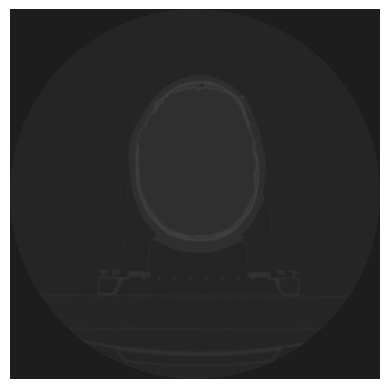

In [9]:
displayImageSlice(testShuffleROI, 110)

In [ ]:
displayImageSlice(testRandomROI, 240)

In [10]:
testShuffleNonROI = negativeControlNonROIOnly(baseImage, baseROI, "shuffled", 10)

In [11]:
testRandomNonROI = negativeControlNonROIOnly(baseImage, baseROI, "randomized", 10)

In [12]:
testRandomSampleNonROI = negativeControlNonROIOnly(baseImage, baseROI, "randomized_sampled", 10)

In [ ]:
displayImageSlice(testRandomSampleNonROI, 240)

### Cropped results for test functions

In [6]:
croppedCT, croppedROI = getCroppedImages(baseImage, baseROI)

original_pixels = sitk.GetArrayFromImage(croppedCT)

randomSeed = 10

In [4]:
cropShuffleROI = negativeControlROIOnly(croppedCT, croppedROI, "shuffled", 10)
cropRandomROI = negativeControlROIOnly(croppedCT, croppedROI, "randomized", 10)
cropRandomSampledROI = negativeControlROIOnly(croppedCT, croppedROI, "randomized_sampled", 10)

cropShuffleNonROI = negativeControlNonROIOnly(croppedCT, croppedROI, "shuffled", 10)
cropRandomNonROI = negativeControlNonROIOnly(croppedCT, croppedROI, "randomized", 10)
cropRandomSampledNonROI = negativeControlNonROIOnly(croppedCT, croppedROI, "randomized_sampled", 10)

In [7]:
nc_type = "shuffled"

cropNCROI = negativeControlROIOnly(croppedCT, croppedROI, nc_type, randomSeed)
cropNCNonROI = negativeControlNonROIOnly(croppedCT, croppedROI, nc_type, randomSeed)

ncROIPixels = sitk.GetArrayFromImage(cropNCROI)
ncNonROIPixels = sitk.GetArrayFromImage(cropNCNonROI)

print("ROI NC checks")
print("0,0,0:", ncROIPixels[0,0,0])
print("-1,-1,-1:", ncROIPixels[-1,-1,-1])
print("7,18,11:", ncROIPixels[7,18,11])


print("Non-ROI NC checks")
print("0,0,0:", ncNonROIPixels[0,0,0])
print("-1,-1,-1:", ncNonROIPixels[-1,-1,-1])
print("7,18,11:", ncNonROIPixels[7,18,11])

ROI NC checks
0,0,0: -968
-1,-1,-1: -998
7,18,11: -999
Non-ROI NC checks
0,0,0: -978
-1,-1,-1: -990
7,18,11: 1129


In [ ]:
original_pixels = sitk.GetArrayFromImage(croppedCT)
shuffled_roi_pixels = sitk.GetArrayFromImage(cropShuffleROI)

np.array_equal(original_pixels, shuffled_roi_pixels)